In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sympy

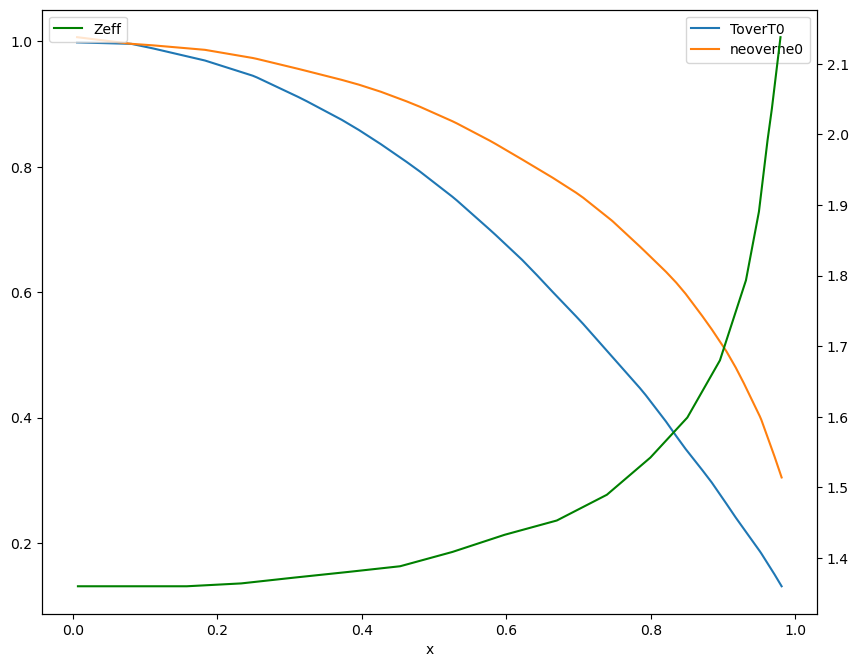

In [2]:
T_data = pd.read_csv("/home/dominik/houlberg-profiles.csv").drop("Zeff", axis=1)

zeff = pd.read_csv("/home/dominik/houlberg-profiles-zeff.csv")

fig, ax = plt.subplots()
T_data.plot(x="x", ax=ax)
ax2 = plt.twinx()
zeff.plot(x="x", ax=ax2, c="g")
plt.legend()

# TODO opisać Sławkowi logikę z wywnioskowywania z tego kompozycji plazmy

In [3]:
import sympy
sympy.init_printing()
rho, T0, Ta, ne0, nea, nC, e, = sympy.symbols("rho T_0 T_a n_{e0} n_{ea} n_{C-6+} e")
n_i = sympy.Function('n_i')(rho)

In [4]:
T_i = (T0 - Ta) * (1 - rho**2) + Ta

In [5]:
T_e = T_i
n_e = (ne0 - nea) * sympy.sqrt(1 - rho**2) + nea

In [6]:
n_C6 = nC

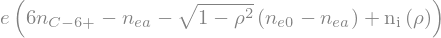

In [7]:
charge_density = (n_i + 6 * n_C6 - n_e) * e

In [8]:
T_C6 = T_i

In [9]:
n_i_solution = sympy.solve(charge_density, n_i)[0]

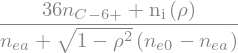

In [10]:
Z_eff = (n_i + 6**2 * n_C6)/n_e

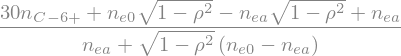

In [11]:
Z_eff.subs(n_i, n_i_solution).simplify()

      fun: 0.012943704088280742
 hess_inv: array([[0.00237366]])
      jac: array([1.74622983e-09])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([0.13728105])

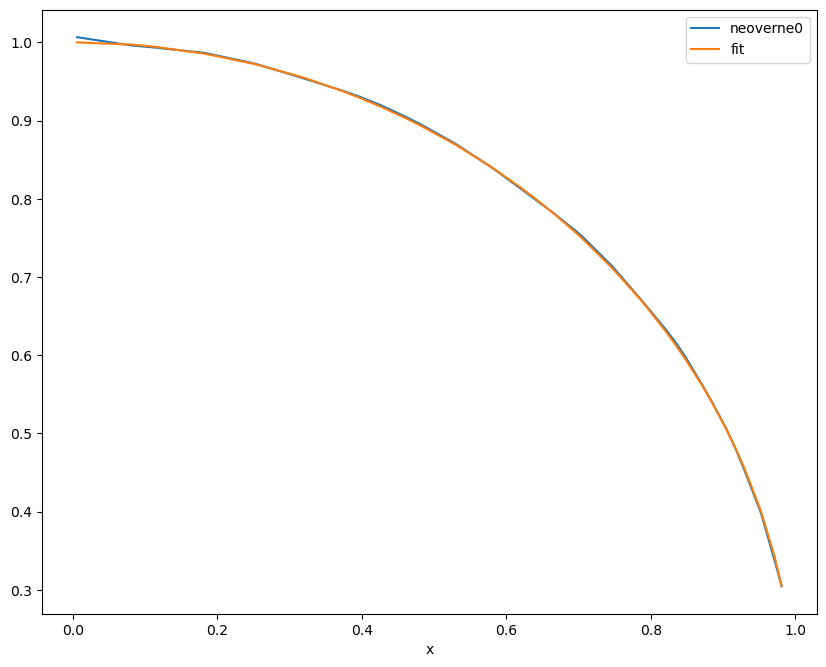

In [12]:
T_data.plot(x='x', y="neoverne0")
n_e_func = sympy.lambdify((nea, rho), n_e.subs({ne0: 1}))
n_e_func_1p = lambda nea: n_e_func(nea, T_data.x)
diff2 = lambda nea: np.linalg.norm(n_e_func_1p(nea) - T_data.neoverne0)
from scipy import optimize
n_minimization = optimize.minimize(diff2, 0.1)
display(n_minimization)

n_e_profile = n_e_func_1p(n_minimization.x)
plt.plot(T_data.x, n_e_profile, label="fit")
plt.legend()

      fun: 0.007022608609574225
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.6429193e-09])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([0.09874966])

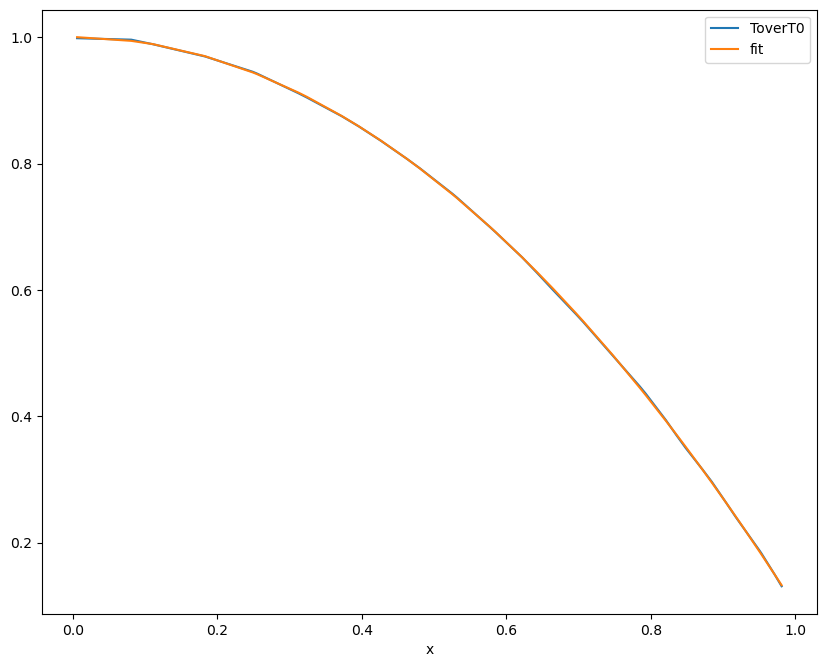

In [13]:
T_data.plot(x='x', y="ToverT0")
T_func = sympy.lambdify((Ta, rho), T_e.subs({T0: 1}))
T_func_1p = lambda Ta: T_func(Ta, T_data.x)
diff2 = lambda Ta: np.linalg.norm(T_func_1p(Ta) - T_data.ToverT0)
from scipy import optimize
T_minimization = optimize.minimize(diff2, 0.1, bounds=[(0, None)])
display(T_minimization)

T_profile = T_func_1p(T_minimization.x)
plt.plot(T_data.x, T_profile, label="fit")
plt.legend()

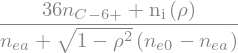

In [14]:
Z_eff

In [15]:
Z_eff_data = sympy.Function("Z_eff^D")(rho)

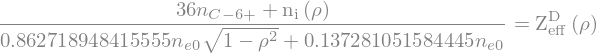

In [25]:
Z_eff_equation = sympy.Eq(
    Z_eff.subs({nea: n_minimization.x[0] * ne0, Ta: T_minimization.x[0] * T0}),
    Z_eff_data
)

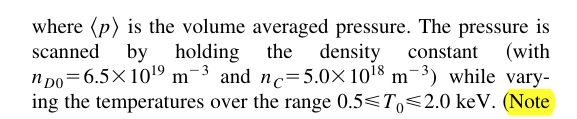

In [31]:
Z_eff_file = pd.read_csv("/home/dominik/houlberg-profiles-zeff.csv")

,x,Zeff
0,0.00678,1.35992
1,0.08213,1.35992
2,0.15749,1.35992
3,0.23284,1.36397
4,0.30517,1.37207
5,0.38051,1.38017
6,0.45284,1.38828
7,0.52516,1.40853
8,0.59747,1.43284
9,0.66978,1.45309


In [46]:
ne0_numerical_solution = sympy.solve(Z_eff_equation.subs({
    rho: 0,
    n_C6: 5e18,
    n_i: 6.5e19,
    Z_eff_data: Z_eff_file.iloc[0].Zeff
}))[0]

In [19]:
difference.diff(ne0)

In [85]:
diff_func = sympy.lambdify((n_C6, ne0, Z_eff_data, rho), difference)
diff_func_grad = sympy.lambdify((n_C6, ne0, Z_eff_data, rho), difference.diff(ne0))
optimizable = lambda ne0: np.linalg.norm(diff_func(5e18, ne0 / 1e20, Z_eff_file.Zeff, Z_eff_file.x))
optimizable_grad = lambda ne0: np.linalg.norm(diff_func_grad(5e18, ne0 / 1e20, Z_eff_file.Zeff, Z_eff_file.x))

<function __main__.<lambda>(ne0)>

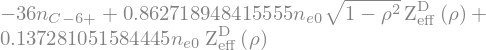

In [86]:
difference

In [87]:
difference.diff(ne0)

In [88]:
optimizable(5)

In [89]:
optimize.minimize(optimizable, 1, bounds=[(0, None)])

      fun: 7.846018098373212e+20
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.])